In [ ]:
import xarray as xr
import warnings
from pathlib import Path

from pyorg.core.geometry import get_cells_area

import pycompo.core.composite as pccompo
import pycompo.core.coord as pccoord
import pycompo.core.ellipse as pcellipse
import pycompo.core.feature_cutout as pcfeatcut
import pycompo.core.filter as pcfilter
import pycompo.core.plot as pcplot
import pycompo.core.significance_testing as pcsig
import pycompo.core.sst_features as pcsst
import pycompo.core.wind as pcwind
import pycompo.core.utils as pcutil

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_template.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
feature_var = config['data']['feature_var']

### Read in data, building SST anomalies and their gradients using Gaussian filter

In [ ]:
varlist = [feature_var] + config['data']['wind_vars'] + \
    config['data']['study_vars']

infiles = []
for var in varlist:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = \
        f"{config['exp']}_tropical_{var}_20200301T000000Z-20200401T000000Z.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=25)
if 'height_2' in dset.coords: dset = dset.drop('height_2')

# Detrend data with climatology
if config['detrend']['switch']:
    feature_var = config['data']['feature_var']

    # Read in data for building the climatology
    inpath = Path(config['data']['inpaths'][feature_var])
    in_pattern = f"{config['exp']}_tropical_{feature_var}_*.nc"
    infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
    dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()
    
    # Detrend dataset with multiyear monthly climatology
    climatology = pcfilter.build_hourly_climatology(
        dset_clim, clim_baseyear=str(config['detrend']['clim_baseyear'])
        )
    rolling_climatology = pcutil.circ_roll_avg(
        climatology, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
    dset[f'{feature_var}_detrend'] = \
        dset[feature_var] - rolling_climatology[feature_var]
    dset[f'{feature_var}_detrend'] = dset[f'{feature_var}_detrend'].compute()
    config['data']['feature_var'] = f'{feature_var}_detrend'
    
dset = pcutil.add_timelag_idx_space(
    dset, feature_var, config['data']['timelag_idx'],
    )
for var in varlist: dset[var] = dset[var].compute()

In [ ]:
# scale separation
filter_vars = [feature_var] + config['data']['wind_vars']
if config['composite']['type'] == 'anomaly':
    filter_vars += config['data']['study_vars']
dset_filter = pcfilter.get_gaussian_filter_bg_ano(
    dset[filter_vars], **config['filter']
    )

if config['composite']['type'] == 'anomaly':
    merge_dsets = [
        dset_filter[[f"{var}_bg" for var in config['data']['wind_vars']]],
        dset_filter[[f"{var}_ano" for var in filter_vars]],
        ]
    grad_var = f"{feature_var}_ano"
elif config['composite']['type'] == 'absolute':
    merge_dsets = [
        dset_filter[[f"{var}_bg" for var in config['data']['wind_vars']]],
        dset_filter[f"{feature_var}_ano"],
        dset,
        ]
    grad_var = feature_var

dset = xr.merge(merge_dsets)
dset = pccoord.calc_sphere_gradient_laplacian(dset, grad_var)
dset['cell_area'] = get_cells_area(dset)
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)

### Detection of SST clusters and cutout of corresponding data

In [ ]:
dset[f"{feature_var}_feature"], feature_props = \
    pcsst.extract_sst_features(dset[f"{feature_var}_ano"], **config['feature'])
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, feature_var, config['cutout']['search_RadRatio'],
    )
feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'],
    )

orig_coords = pccoord.get_coords_orig(dset)
feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )
feature_data = pcwind.add_wind_grads(feature_data, feature_props, grad_var)
feature_data = pcwind.add_rotate_winds(feature_data, feature_props)
feature_compo_data = pccompo.get_compo_coords_ds(feature_data, config)

# Significance tests
_, pvalue = pcsig.calc_compo_ttest(feature_compo_data, popmean=0.0)
local_significane = pcsig.get_local_significance(pvalue, alpha=0.05)
field_significane = pcsig.get_field_significance(pvalue, alpha_FDR=0.1)

### Visualization

#### SST preprocessing steps

In [ ]:
if config['detrend']['switch']:
    # User settings of spatiotemporal plotting area
    lat_slice = slice(0, 10)
    lat_slice = slice(-15, 15)
    lon_slice = slice(-170, -160)
    lon_slice = slice(-179, -140)
    time_index = 0

    pcplot.plot_preprocessing_overview_map(
        dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
        config['data']['feature_var'], config['feature']['threshold'], 
        )

#### Remapping

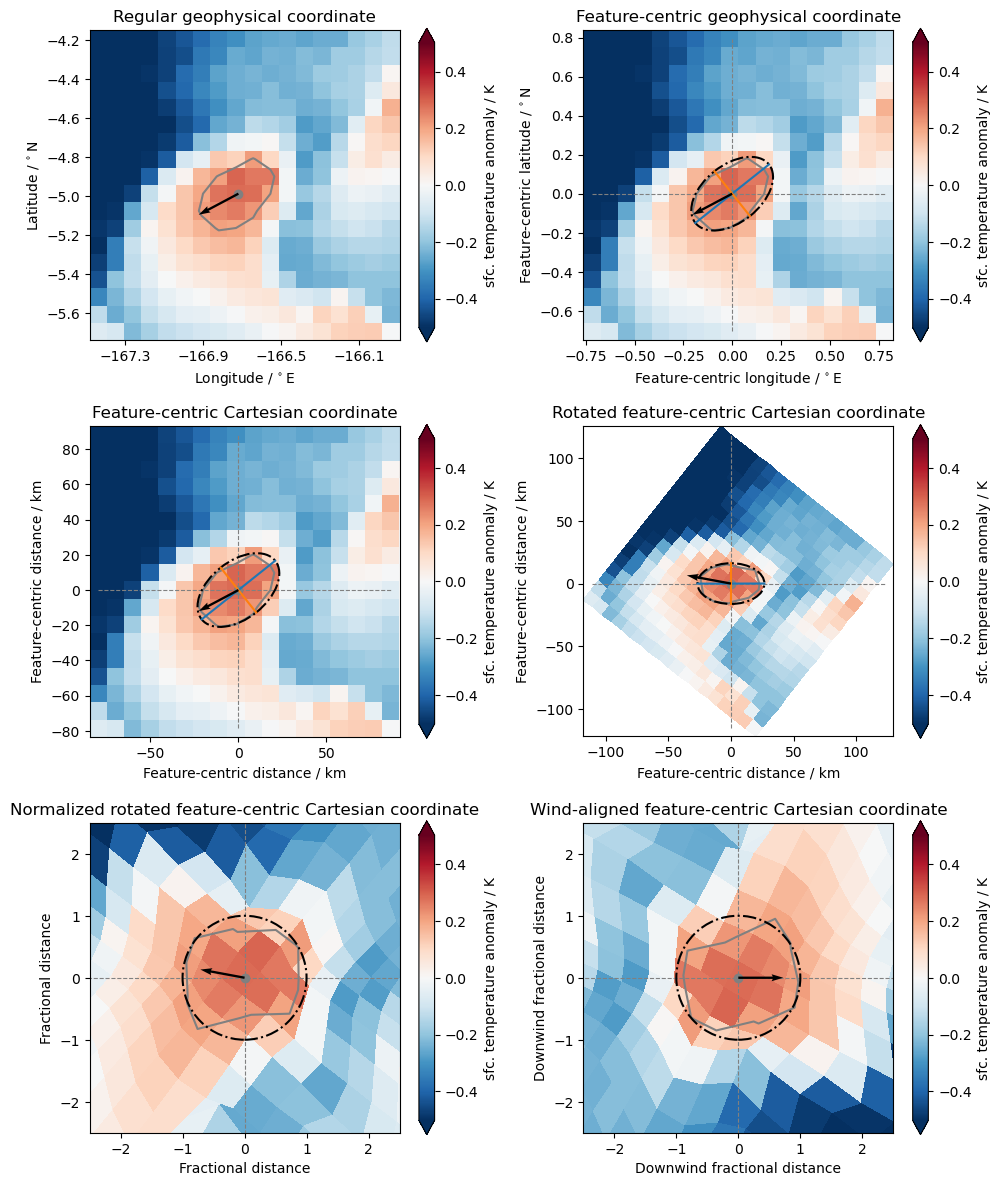

In [ ]:
import importlib as implib
implib.reload(pcplot)

feature_id = 103 #38
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{feature_var}_ano", config['feature']['threshold'],
    )

#### Plain composites

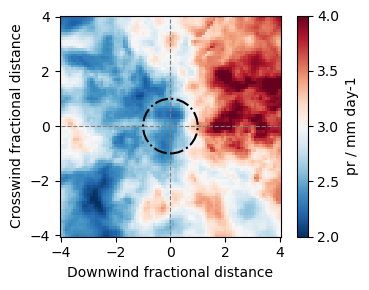

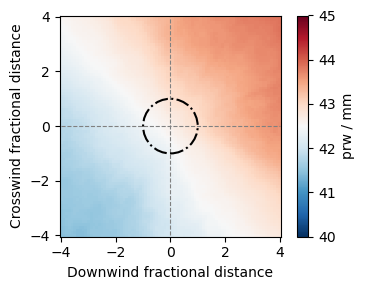

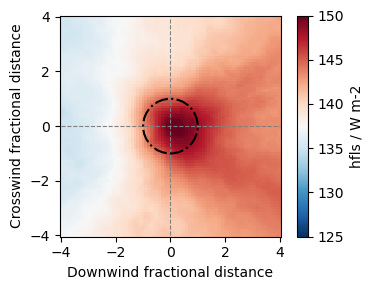

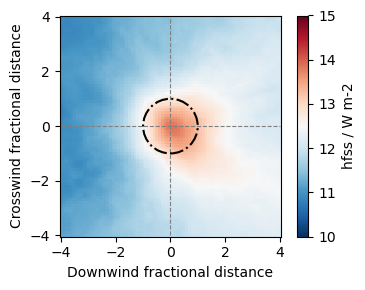

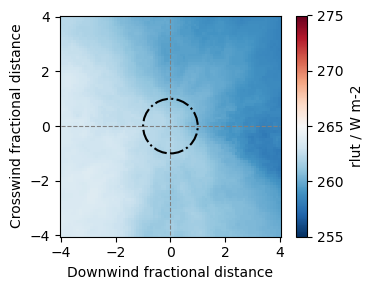

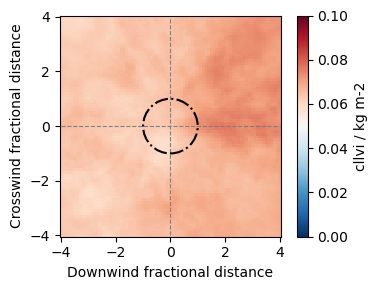

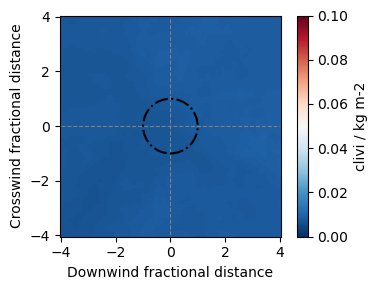

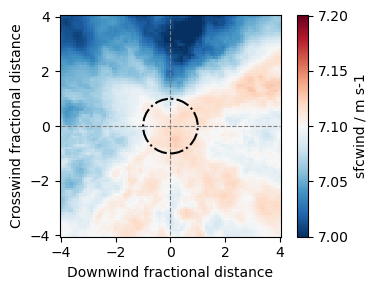

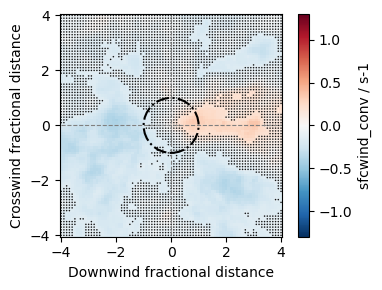

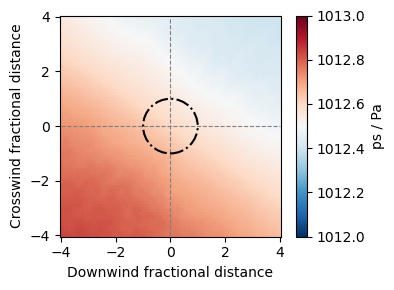

In [49]:
import importlib as implib
implib.reload(pcplot)
implib.reload(pccompo)

#for var in feature_compo_data.data_vars:
for var in config['data']['study_vars']:
    plot_ds = pccompo.adjust_units(feature_compo_data, [var])
    plot_ds = plot_ds[var].mean(dim='feature')
    if plot_ds.ndim != 2:
        continue
    pcplot.plot_composite(plot_ds, field_significane[var])

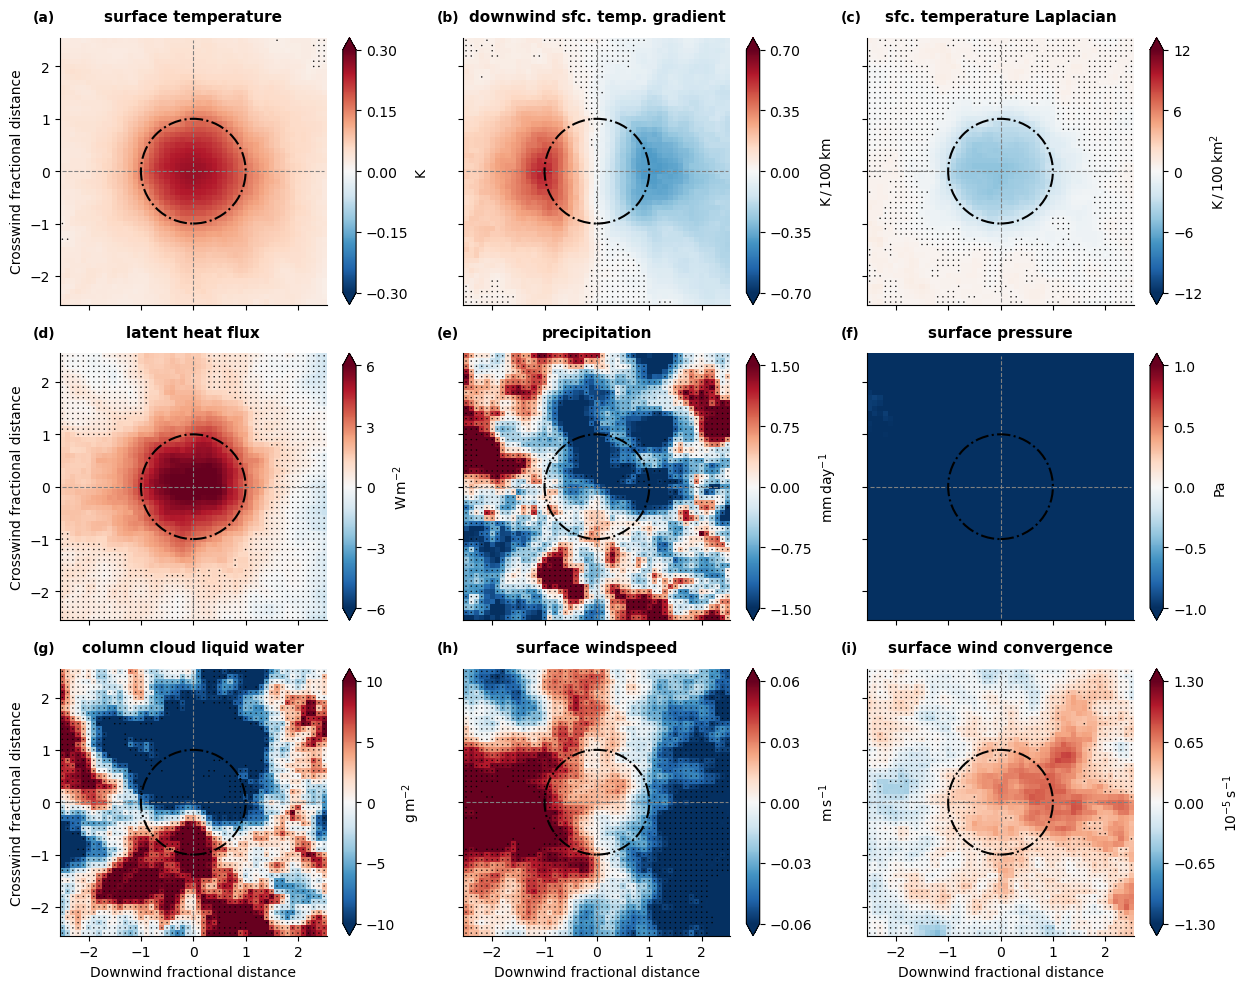

In [59]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano', 'pr_ano',
    'ps_ano', 'cllvi_ano', 'sfcwind_ano', 'sfcwind_conv_ano']

pcplot.plot_composite_overview(
    pccompo.adjust_units(feature_compo_data.mean(dim='feature'), vars),
    sigmask, vars,
    )

#### Composite crosssections

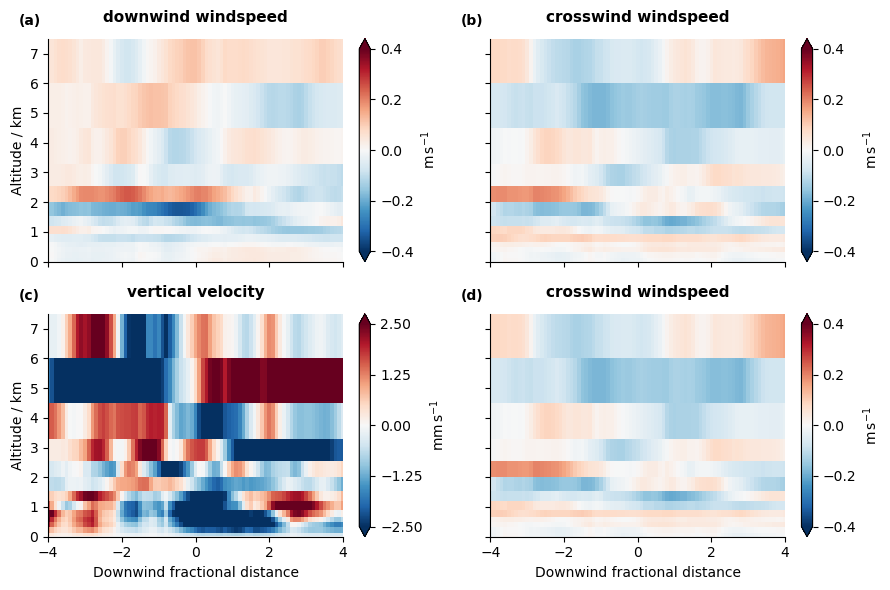

In [5]:
import pycompo.core.utils as pcutil
import importlib as implib
implib.reload(pcplot)

vars = ['ua_ano', 'va_ano', 'wa_ano', 'va_ano']
ysel = slice(38, 42)

feature_compo_data = pcutil.add_metric_altitude(feature_compo_data, config)
alltrops_compo_adjusted = pccompo.adjust_units(feature_compo_data, vars)
pcplot.plot_compo_crosssection(
    alltrops_compo_adjusted.mean(dim='feature'), vars, ysel=ysel,
    )

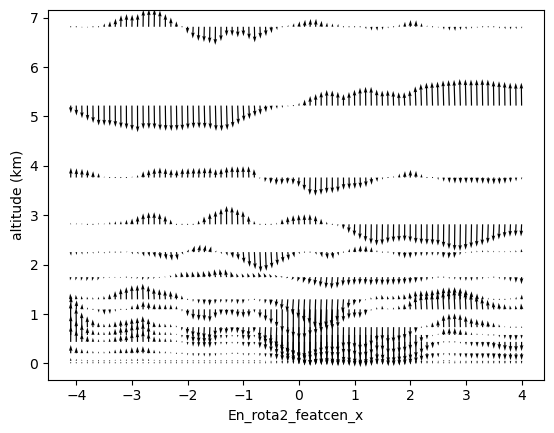

In [19]:
import matplotlib.pyplot as plt

# Ensure we pass plain numpy arrays with matching shapes:
# x: (x,), y: (height,), U and V: (height, x)
x_coords = alltrops_compo_adjusted['En_rota2_featcen_x'].values
y_coords_km = (alltrops_compo_adjusted['altitude'] / 1000).values

# Use prepared 2D arrays u and w (shape: height x)
U = alltrops_compo_adjusted['ua_ano'].mean(dim='feature').sel(y=slice(38, 42)).\
    mean(dim='y').transpose().values
V = alltrops_compo_adjusted['wa_ano'].mean(dim='feature').sel(y=slice(38, 42)).\
    mean(dim='y').transpose().values

pl = plt.quiver(x_coords, y_coords_km, U, V)
plt.xlabel('En_rota2_featcen_x')
plt.ylabel('altitude (km)')
plt.show()